In [3]:
# Initialize Otter
import otter
grader = otter.Notebook("hw09.ipynb")

# Homework 9: Bootstrap, Resampling, CLT

**Author**: Yanay Rosen

**Helpful Resource:**
- [Python Reference](http://data8.org/su21/python-reference.html): Cheat sheet of helpful array & table methods used in Data 8!

**Reading**: 
* [Estimation](https://inferentialthinking.com/chapters/13/Estimation.html)
* [Why the mean matters](https://inferentialthinking.com/chapters/14/Why_the_Mean_Matters.html)

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load the necessary libraries. Each time you start your server, you will need to execute this cell again to load the tests.

For all problems that you must write explanations and sentences for, you **must** provide your answer in the designated space. **Moreover, throughout this homework and all future ones, please be sure to not re-assign variables throughout the notebook!** For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!

**Deadline:**

This assignment is due Wednesday, 7/28 at 11:59 P.M. PDT. Late work will not be accepted as per the [policies](http://data8.org/su21/policies.html) page.

**Note: This homework has hidden tests on it. That means even though tests may say 100% passed, doesn't mean your final grade will be 100%. We will be running more tests for correctness once everyone turns in the homework.**

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the policies page to learn more about how to learn cooperatively.

You should start early so that you have time to get help if you're stuck. Office hours are held Monday-Friday. The schedule appears on [http://data8.org/su21/office-hours.html](http://data8.org/sp21/office-hours.html).

In [4]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import *

# These lines do some fancy plotting magic.",
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## 1. Preliminaries

Orville has collected some data about the number of kernels of microwave popcorn that pop when he microwaves a bag for 3 minutes. **`n` is the total number of kernels popped out of 460 kernels.**

We normally investigate the random variation among our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if Orville had known what the population looked like, he would have known `n` and would not have had any reason to think about random sampling. However, he didn't know what the population looked like, so he couldn't have run the simulations that we normally do. 

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. **Given *just* a random sample of popcorn kernels, we'll estimate `n`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.**  This is an example of *statistical inference*.

We (popcorn eaters/Orville) want to know the number of popcorn kernels that will pop when we microwave a bag for 3 minutes. That number is `n`.

We only see the results from microwaving one bag (assumed to be a random sample with replacement from among all possible bags), so we have to use estimation.

#### Question 1.1
Is `n` a population parameter or a statistic?  If we use our random sample to compute a number that is an estimate of `n`, is that a population parameter or a statistic?

Set `n` and `N_estimate` to either the string `"parameter"` or `"statistic"` to indicate whether each value is a parameter or a statistic. **(3 Points)**

<!--
BEGIN QUESTION
name: q1_1
manual: false
points:
 - 0
 - 0
 - 3
-->

In [5]:
n = "parameter"
N_estimate = "statistic"

In [6]:
grader.check("q1_1")

q1_1 results: All test cases passed!

To make the situation realistic, we're going to hide the true (expected) number of popped kernels from you.  You'll have access only to random sample `observations`. `observations` has a column called `popped` with value `1` if that kernel popped and `0` if it did not.

**Dataset Details:**
- Origin: This data is fake. It was randomly generated following the parameters in this report: http://polymerambassadors.org/pdf/microwavepop.pdf so it is reasonably plausible.
- Extra Context: None.

In [7]:
observations = Table.read_table("popcorn.csv")
observations

Popped
1
0
1
1
1
1
1
1
1
1


#### Question 1.2
Logically, it makes sense to estimate the sum of the population using the sum of our sample. Write a line of code that computes that statistic.  

Compute an estimate of `n` called `sum_estimate`. **(3 Points)**

<!--
BEGIN QUESTION
name: q1_2
manual: false
points:
 - 0
 - 3
-->

In [8]:
sum_estimate = sum(observations.column("Popped"))
sum_estimate

429

In [9]:
grader.check("q1_2")

q1_2 results: All test cases passed!

#### Question 1.3
It can take a while to manually count out the 460 kernels in a bag, so we also want an estimate that would require us to just count some of the kernels. Write a function called sum115 to estimate `n` based on just the first 115 popcorn kernels.

Compute a new estimate of `n` called `sum_115_estimate`. **(4 Points)**

<!--
BEGIN QUESTION
name: q1_3
manual: false
points:
 - 0
 - 0
 - 4
-->

In [10]:
def sum115(kernels_arr):
    est_115 = 0
    for i in np.arange(115):
        est_115 = est_115 + kernels_arr.item(i)
    return est_115 * (460/115)

sum_115_estimate = sum115(observations.column("Popped"))
sum_115_estimate

420.0

In [11]:
grader.check("q1_3")

q1_3 results: All test cases passed!

#### Question 1.4
Assign either `1` or `2` to `smaller_variance` if you think:

1. sum based estimate 
2. sum115 based estimate will have smaller variance. 

**(3 Points)**

<!--
BEGIN QUESTION
name: q1_4
manual: false
points:
 - 0
 - 3
-->

In [12]:
smaller_variance = 1
smaller_variance

1

In [13]:
grader.check("q1_4")

q1_4 results: All test cases passed!

## 2. Resampling
To do this, we'll use resampling.  That is, we won't draw new samples from our population.  Rather we sample from our current sample, or "resample."

Why does that make sense?

When we try to find the value of a population parameter, we ideally would like to use the whole population. However, we often only have access to one sample and we must use that to estimate the parameter instead.

Here, we would like to use the population of kernels to draw more samples and run a simulation about estimates of `n`.  But we still only have our sample.  So, we **use our sample in place of the population** to run the simulation. We resample from our original sample with replacement as many times as there are elements in the original sample. This resampling technique is called *bootstrapping*. 

Note that in order for bootstrapping to work well, you must start with a large, random sample. Then the Law of Large Numbers says that with high probability, your sample is representative of the population.

#### Question 2.1
Write a function called `simulate_resample`. The function should take one argument `tbl`, which is a table like `observations`. The function should generate and return a resample from the observed kernels in `tbl`. **(3 Points)**

<!--
BEGIN QUESTION
name: q2_1
manual: false
points:
 - 0
 - 0
 - 3
-->

In [14]:
def simulate_resample(tbl):
    return tbl.sample(with_replacement = True)

simulate_resample(observations) # Don't delete this line

Popped
1
1
1
1
1
1
0
1
1
1


In [15]:
grader.check("q2_1")

q2_1 results: All test cases passed!

We'll use many resamples at once to see what estimates typically look like.  However, we don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's first answer some questions about our resample.

#### Question 2.2
Which of the following statements are true?


1. The resample can contain the same popcorn kernel multiple times.
2. The resample can contain popcorn kernels that were not in the original sample.
3. The resample contains either zero or one copy of each popcorn kernel.
4. The resample has exactly the same sample size as the original sample.
5. The histogram of the resample can look somewhat different from the histogram of the original sample.

Assign `true_statements` to an **array** of the number(s) corresponding to correct statements. **(5 Points)**

*Note:* The "original sample" refers to `observations`, and the "resample" refers to the output of one call of `simulate_resample()`. 

<!--
BEGIN QUESTION
name: q2_2
manual: false
points:
 - 0
 - 5
-->

In [16]:
true_statements = make_array(1,4,5)

In [17]:
grader.check("q2_2")

q2_2 results: All test cases passed!

Now let's write a function to do many resamples at once.

#### Question 2.3
Write a function called `sample_estimates`.  It should take 3 arguments:
1. `popcorn_tbl`: A table from which the data should be sampled.  The table will look like `observations`. 
2. `statistic`: A *function* that takes in an array of kernels as its argument and computes a statistic from the array (i.e. returns a calculated number). 
3. `repetitions`: The number of simulations to perform.

*Hint: You should use the function `simulate_resample` which you defined in Question 2.1*

The function should simulate `repetitions` number of samples **with replacement** from the given table. For each of those samples, it should compute the statistic on that sample. Then it should **return an array** containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly. **(6 Points)**

<!--
BEGIN QUESTION
name: q2_3
manual: false
points:
 - 0
 - 0
 - 0
 - 6
-->

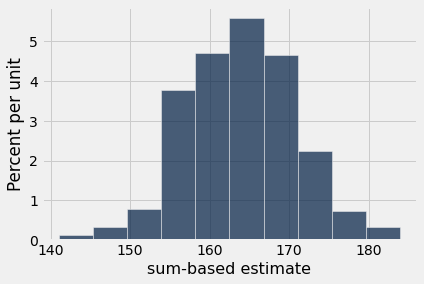

In [18]:
def sample_estimates(popcorn_tbl, statistic, repetitions):
    stats = make_array()
    for i in np.arange(repetitions):
        resampled_tbl = simulate_resample(popcorn_tbl)
        one_stat = statistic(resampled_tbl.column(0))
        stats = np.append(stats,one_stat)
    return stats

# DON'T CHANGE THE CODE BELOW THIS COMMENT! (If you do, you will fail the hidden test.)
# This is just an example to test your function.
# This should generate an empirical histogram of sum-based estimates
# of n from samples of size 230 if n is 159.  This should be very roughly bell shaped and centered at about 164
# answer, make sure that's what you see!
num_repetitions = 500
one_sample = Table.read_table("one_sample.csv")
example_estimates = sample_estimates(
    one_sample,
    sum,
    num_repetitions)
Table().with_column("sum-based estimate", example_estimates).hist()

In [19]:
grader.check("q2_3")

q2_3 results: All test cases passed!

Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our estimates of `n` would have varied from sample to sample.

#### Question 2.4
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *sum-based estimates* of `n`.  Use 3000 replications and save the estimates in an array called `bootstrap_sum_based_estimates`. **(3 Points)**

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

*Note: we want sum-based estimates, not sum115-based estimates*

<!--
BEGIN QUESTION
name: q2_4
manual: false
points:
 - 0
 - 3
-->

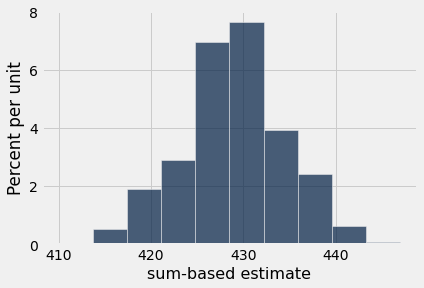

In [20]:
bootstrap_sum_based_estimates = sample_estimates(observations, sum, 3000)

# Don't change the code below! This plots bootstrap_mean_based_estimates.
Table().with_column("sum-based estimate", bootstrap_sum_based_estimates).hist(bins=10) 

In [21]:
grader.check("q2_4")

q2_4 results: All test cases passed!

#### Question 2.5
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *sum115 estimates* of `n`.  Use 3000 replications and save the estimates in an array called `bootstrap_sum115_estimates`. **(3 Points)**

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

*Hint:* Similar to the question above, you should pass in a function as your second argument. In this case, you want **sum115** estimates.

<!--
BEGIN QUESTION
name: q2_5
manual: false
points:
 - 0
 - 3
-->

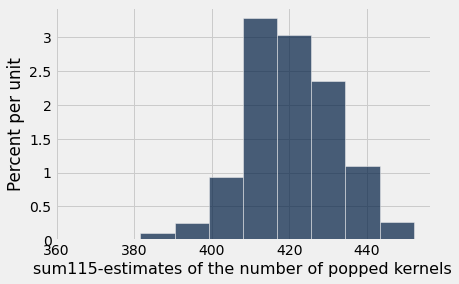

In [22]:
bootstrap_sum115_estimates = sample_estimates(observations.take(np.arange(115)), sum, 3000) * 4

# Don't change the code below! This plots bootstrap_sum115_estimates.
Table().with_column("sum115-estimates of the number of popped kernels", bootstrap_sum115_estimates).hist(bins=10) 

In [23]:
grader.check("q2_5")

q2_5 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 2.6
`n` was actually 432! Recall that **`n` is the population sum**. Compare the histograms of estimates you generated in 2.4 and 2.5 and answer the following questions:

1. How does the distribution of values for the sum-based estimates differ from the sum115 based estimates? Do both distributions contain the true sum value?
2. Which estimator do you think will work well for other distributions?

**(5 Points)**

<!--
BEGIN QUESTION
name: q2_6
manual: true
-->

(1)The sum-based estimates are centered at about 430 and the sum115 based ones are centered at about 420.Both distributions contain the true sum value. (2) The sum-based estimator will work well for other distributions for its estimates are closer to the true sum value.

<!-- END QUESTION -->



## 3. Computing Intervals

#### Question 3.1
Compute an interval that covers the middle 95% of the **sum-based bootstrap estimates**.  Assign your values to `left_end_1` and `right_end_1`. 

*Hint:* Use the `percentile` function! Read up on its documentation [here](http://data8.org/su21/python-reference.html).

Verify that your interval looks like it covers 95% of the area in the histogram. The red dot on the histogram is the value of the parameter (432). **(4 Points)**

<!--
BEGIN QUESTION
name: q3_1
manual: false
points:
 - 0
 - 2
 - 2
-->

Middle 95% of bootstrap estimates: [418.000000, 440.000000]


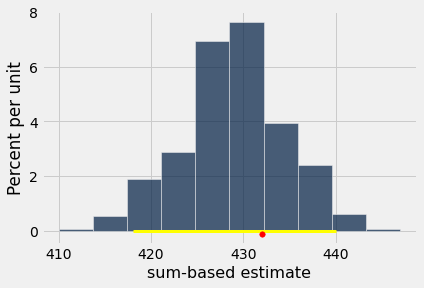

In [24]:
left_end_1 = percentile(2.5,bootstrap_sum_based_estimates)
right_end_1 = percentile(97.5,bootstrap_sum_based_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end_1, right_end_1))

# Don't change the code below! It draws your interval and N on the histogram of sum-based estimates.
import matplotlib.pyplot as plt
Table().with_column("sum-based estimate", bootstrap_sum_based_estimates).hist(bins=10) 
plt.plot(make_array(left_end_1, right_end_1), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(432, -0.001, color='red', s=30, zorder=2);

In [25]:
grader.check("q3_1")

q3_1 results: All test cases passed!

#### Question 3.2
Write code that simulates the sampling and bootstrapping process again, as follows **(6 Points)**:

1. Generate a new set of random observations that Orville might have seen by sampling from the `population` table we have created for you below. Your sample should have the same number of rows as the original `observations` sample.
2. Compute an estimate of `n` from these new observations, using `sum115_based_estimator`.
3. Using only the new observations, compute 9,000 bootstrap estimates of `n`. You can use a function you previously defined to do this.
4. Plot these bootstrap estimates (this line of code is given to you) and compute an interval covering the middle 95%.

*Note:* Traditionally, when we bootstrap using a sample from the population, that sample is usually a simple random sample (i.e., sampled uniformly at random from the population without replacement). However, if the population size is big enough, the difference between sampling with replacement and without replacement is negligible. Think about why that's the case! This is why when we define `new_observations`, we sample with replacement.

<!--
BEGIN QUESTION
name: q3_2
manual: false
points:
 - 3
 - 3
-->

New sum115-based estimate: 424.000000
Middle 95% of bootstrap estimates: [418.000000, 439.000000]


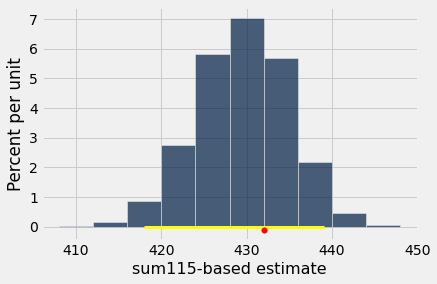

In [26]:
# DO NOT CHANGE THESE LINES
from scipy.stats import bernoulli
population = Table().with_column("Popped", bernoulli.rvs(p=432/460, size=100000))
# YOUR CODE BELOW HERE

new_observations = population.sample(observations.num_rows)
new_sum115_based_estimate = sum115(new_observations.column(0))
new_bootstrap_estimates = sample_estimates(new_observations, sum, 9000)
Table().with_column("sum115-based estimate", new_bootstrap_estimates).hist(bins=10)
new_left_end = percentile(2.5,new_bootstrap_estimates)
new_right_end = percentile(97.5,new_bootstrap_estimates)

# Don't change code below this line!
print("New sum115-based estimate: {:f}".format(new_sum115_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(432, -0.001, color='red', s=30, zorder=2);

In [27]:
grader.check("q3_2")

q3_2 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 3.3
Does the interval covering the middle 95% of the new bootstrap estimates include `n`?  If you ran that cell 2000 times and generated 2000 intervals, how many of those intervals would you expect to include `n`? **(5 Points)**

<!--
BEGIN QUESTION
name: q3_3
manual: true
-->

Yes. Approximately 1900 of the 2000 intervals.

<!-- END QUESTION -->



Let's look at what happens when we use a small number of resamples:

<img src="smallrepsumhist.png" width="525"/>

This histogram and confidence interval was generated using 10 resamples of `new_observations`.

<!-- BEGIN QUESTION -->

#### Question 3.4
In the cell below, explain why this histogram and confidence interval look different from the ones you generated previously in Question 3.2 where the number of resamples was 10,000. **(5 Points)**

<!--
BEGIN QUESTION
name: q3_4
manual: true
-->

In question 3.2, the number of resamples was 10000, according to the Central Limit Theorem, the probability distribution of the sum or average of a large random sample drawn with replacement will be roughly normal, as shown in the figure of q3.2. And in the above case, the number of resamples was small, not enough to generate a bell-shape distribution()

<!-- END QUESTION -->



## 4. CLT Math

#### Question 4.1
Does CLT apply to sum-based-bootstrap-estimates? If you think it does, assign `True` to `sum_clt`, else assign `False`. **(3 Points)**

<!--
BEGIN QUESTION
name: q4_1
manual: false
points:
 - 0
 - 3
-->

In [28]:
sum_clt = True

In [29]:
grader.check("q4_1")

q4_1 results: All test cases passed!

#### Question 4.2
Let's define a new estimator function for the sum. This new estimator will do the following:

1. Take the mean of the kernel's popped values (remember these are either 0 or 1).
2. Multiply the mean by the sample size (460)

Does CLT apply to this new-estimator-based-bootstrap-estimates? If you think it does, assign `True` to `new_clt`, else assign `False`. **(3 Points)**

<!--
BEGIN QUESTION
name: q4_2
manual: false
points:
 - 0
 - 3
-->

In [30]:
new_clt = True

In [31]:
grader.check("q4_2")

q4_2 results: All test cases passed!

#### Question 4.3

What happens to the width of a histogram when we multiply its values by some number `a`? What does this tell us about the standard deviation of the values after we multiply the values by `a`?

Complete the following sentence:

"The standard deviation of the values `blank_1` by a factor of `blank_2`."

Assign `blank_1` to either `"increases"` or `"decreases"`, and assign `blank_2` to a string corresponding to the factor they change by. **(3 Points)**

<!--
BEGIN QUESTION
name: q4_3
manual: false
points:
 - 0
 - 2
 - 1
-->

In [32]:
blank_1 = "increases"
blank_2 = "a"

# Don't change this line!
print(f"The standard deviation of the values {blank_1} by a factor of {blank_2}.")

The standard deviation of the values increases by a factor of a.


In [33]:
grader.check("q4_3")

q4_3 results: All test cases passed!

<!-- BEGIN QUESTION -->

#### Question 4.4
Of the two estimates, sum and sum115, which will have the highest standard deviation? Explain.

Then, state the standard deviation of the sample sum. **(7 Points)**

<!--
BEGIN QUESTION
name: q4_4
manual: true
-->

(1)The sum115 estimates will have the highest standard deviation. Because the sum115 has a sample size of 115, and that of sum being 460, according to the definition of resample sum SD, it should be Sample SD / sqrt(Sample Size), with smaller sample size, we get a higher SD.
(2)The standard deviation of the sample sum is  SD of sample sum = population SD / sqrt(sample size).

<!-- END QUESTION -->



## 5. The CLT and Book Reviews

Your friend has recommended you a book, so you look for it on an online marketplace. You decide to look at reviews for the book just to be sure that it's worth buying. Let's say that on Amazon, the book only has 80% positive reviews. On GoodReads, it has 95% positive reviews. You decide to investigate a bit further by looking at the percentage of positive reviews for the book on 5 different websites that you know of, and you collect these positive review percentages in a table called `reviews.csv`.

**NOTE: For this section only, we've made all the tests public.**

Here, we've loaded in the table for you.

In [34]:
reviews = Table.read_table("reviews.csv") 
reviews

Positive Review Percentage
80
96
33
65
95


**Question 5.1**. Calculate the average percentage of positive reviews from your sample and assign it to `initial_sample_mean`. **(3 Points)**

<!--
BEGIN QUESTION
name: q5_1
manual: false
points:
 - 3
-->

In [35]:
initial_sample_mean = np.mean(reviews.column(0))
initial_sample_mean

73.8

In [36]:
grader.check("q5_1")

q5_1 results: All test cases passed!

You've calculated the average percentage of positive reviews from your sample, so now you want to do some inference using this information. 

**Question 5.2**. First, simulate 5000 bootstrap resamples of the positive review percentages. For each bootstrap resample, calculate the resample mean and store the resampled means in an array called `resample_positive_percentages`. Then, plot a histogram of the resampled means. **(5 Points)**

<!--
BEGIN QUESTION
name: q5_2
manual: false
points:
 - 0
 - 5
-->

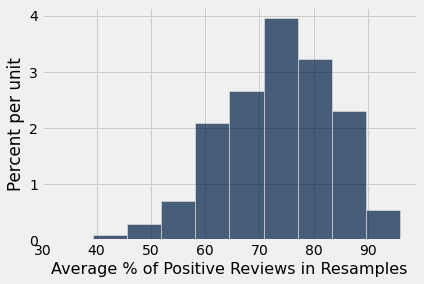

In [37]:
resample_positive_percentages = make_array()

for i in np.arange(5000):
    resample = reviews.sample()
    resample_avg_positive = np.mean(resample.column(0))
    resample_positive_percentages = np.append(resample_positive_percentages,resample_avg_positive)
    
# Do NOT change these lines.
(Table().with_column("Average % of Positive Reviews in Resamples", 
                     resample_positive_percentages).hist("Average % of Positive Reviews in Resamples"))

In [38]:
grader.check("q5_2")

q5_2 results: All test cases passed!

According to the Central Limit Theorem, the probability distribution of the sum or average of a *large random sample* drawn with replacement will be roughly normal, regardless of the distribution of the population from which the sample is drawn. 

**Question 5.3**. Note the statement about the sample being large and random. Is this sample large and random? Give a brief explanation.

Assign `True` or `False` to `is_large` and `is_random`. **(3 Points)**


*Note: The setup at the beginning of this exercise explains how the sample was gathered.*

<!--
BEGIN QUESTION
name: q5_3
manual: false
points:
 - 0
 - 1
 - 2
-->

In [39]:
is_large = False
is_random = False

In [40]:
grader.check("q5_3")

q5_3 results: All test cases passed!

**Question 5.4**. What is the shape of the empirical distribution of the average percentage of positive reviews based on our original sample? What value is the distribution centered at? Assign your answer to the variable `initial_sample_mean_distribution`--your answer should be either `1`, `2`, `3`, or `4` corresponding to the following choices:

*Hint: Look at the histogram you made in Question 4.2. Run the cell that generated the histogram a few times to check your intuition.*

1. The distribution is approximately normal because of the Central Limit Theorem, and it is centered at the original sample mean.
2. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is centered at the original sample mean.
3. The distribution is approximately normal because of the Central Limit Theorem, but it is not centered at the original sample mean.
4. The distribution is not necessarily normal because the Central Limit Theorem may not apply, and it is not centered at the original sample mean.

**(3 Points)**

<!--
BEGIN QUESTION
name: q5_4
manual: false
points:
 - 0
 - 3
-->

In [41]:
initial_sample_mean_distribution = 2

In [42]:
grader.check("q5_4")

q5_4 results: All test cases passed!

Though you have an estimate of the true percentage of positive reviews (the sample mean), you want to measure how variable this estimate is. 

**Question 5.5**. Find the standard deviation of your resampled average positive review percentages, which you stored in `resample_positive_percentages`, and assign the result to the variable `resampled_means_variability`. **(3 Points)**

A convenient way to calculate standard deviation is found [here](https://www.inferentialthinking.com/chapters/14/2/Variability.html#Standard-Deviation) in the textbook. You can also read up on how it relates to variance.

<!--
BEGIN QUESTION
name: q5_5
manual: false
points:
 - 0
 - 3
-->

In [43]:
resampled_means_variability = np.std(resample_positive_percentages)
resampled_means_variability

10.459311114294287

In [44]:
grader.check("q5_5")

q5_5 results: All test cases passed!

This estimate is pretty variable! To make the estimate less variable, let's say you found a way to randomly sample reputable marketplaces from across the web which sell this book. Let's say that there are up to 150 of these marketplaces. The percentages of positive reviews are loaded into the table `more_reviews`.

In [45]:
# Just run this cell
more_reviews = Table.read_table("more_reviews.csv")
more_reviews

Positive Review Percentage
75
79
90
73
92
86
100
100
64
61


In the next few questions, we'll test an important result of the Central Limit Theorem. According to the CLT, the standard deviation of all possible sample means can be calculated using the following formula:

$$
\text{SD of all possible sample means} = \dfrac{\text{Population SD}}{\sqrt{\text{sample size}}}
$$

This formula gives us another way to approximate the SD of the sample means other than calculating it empirically. We can test how well this formula works by calculating the SD of sample means for different sample sizes.

The following code calculates the SD of sample means using the CLT and empirically for a range of sample sizes. Then, it plots a scatter plot comparing the SD of the sample means calculated with both methods. Each point corresponds to a different sample size. 

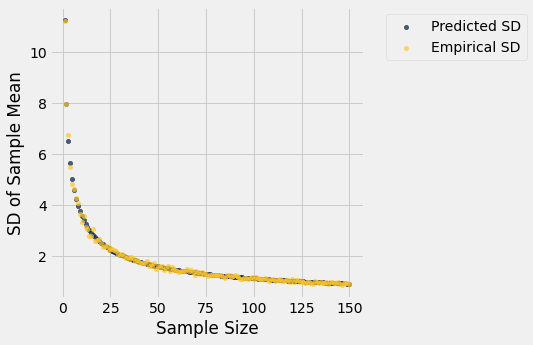

In [46]:
# Just run this cell. It's not necessary for you to read this code, but you can do 99% of this on your own!
# Note: this cell might take a bit to run.

def empirical_sample_mean_sd(n):
    sample_means = make_array()
    for i in np.arange(500):
        sample = more_reviews.sample(n).column('Positive Review Percentage') 
        sample_mean = np.mean(sample) 
        sample_means = np.append(sample_means, sample_mean) 
    return np.std(sample_means)

def predict_sample_mean_sd(n):
    return np.std(more_reviews.column(0)) / (n**0.5)

sd_table = Table().with_column('Sample Size', np.arange(1,151))
predicted = sd_table.apply(predict_sample_mean_sd, 'Sample Size')
empirical = sd_table.apply(empirical_sample_mean_sd, 'Sample Size')
sd_table = sd_table.with_columns('Predicted SD', predicted, 'Empirical SD', empirical)
sd_table.scatter('Sample Size')
plt.ylabel("SD of Sample Mean");

Oftentimes, when conducting statistical inference, you'll want your estimate of a population parameter to have a certain accuracy. It is common to measure the accuracy of an estimate using the SD of the estimate--as the SD goes down, your estimate becomes less variable. As a result, the width of the confidence interval for your estimate decreases (think about why this is true). We know from the Central Limit Theorem that when we estimate a sample mean, the SD of the sample mean decreases as the sample size increases (again, think about why this is true).   

**Question 5.6**. Assign the numbers corresponding to all true statements to an array called `sample_mean_sd_statements`. 

**Note**: This [section](https://www.inferentialthinking.com/chapters/10/2/Sampling_from_a_Population.html) of the textbook illustrates an example of the Law of Large Numbers at work. Note that the Law of Large Numbers is the same as the Law of Averages.

1. The law of large numbers tells us that the distribution of a large random sample should resemble the distribution from which it is drawn.
2. The law of large numbers guarantees that empirical and predicted sample mean SDs will be exactly equal to each other when the sample size is large.
3. The law of large numbers guarantees that empirical and predicted sample mean SDs will be approximately equal to each other when the sample size is large.
4. The plot above shows that as our sample size increases, our estimate for the true percentage of positive reviews becomes more accurate.
5. The plot above shows that the size of the population affects the SD of the sample means.
6. The SD of the sample means is proportional to the square root of the sample size. 
7. The SD of the sample means is proportional to 1 divided by the square root of the sample size. 

**(6 Points)**

<!--
BEGIN QUESTION
name: q5_6
manual: false
points:
 - 0
 - 6
-->

In [49]:
sample_mean_sd_statements = make_array(1,4,7)

In [50]:
grader.check("q5_6")

q5_6 results: All test cases passed!

**Question 5.7**. Imagine you are asked to estimate the true average percentage of positive reviews for this book and you have not yet taken a sample of review websites. Which of these is the best way to decide how large your sample should be to achieve a certain level of accuracy for your estimate of the true average percentage of positive reviews? Assign `sample_size_calculation` to either `1`, `2`, or `3` corresponding to the statements below.

*Note: Assume you know the population SD or can estimate it with reasonable accuracy.*
1. Take many random samples of different sizes, then calculate empirical confidence intervals using the bootstrap until you reach your desired accuracy. 
2. Use the Central Limit Theorem to calculate what sample size you need in advance. 
3. Randomly pick a sample size and hope for the best.

**(3 Points)**

<!--
BEGIN QUESTION
name: q5_7
manual: false
points:
 - 0
 - 3
-->

In [55]:
sample_size_calculation = 2

In [56]:
grader.check("q5_7")

q5_7 results: All test cases passed!

### 6. Parametric Bootstrapping [OPTIONAL]
### All the following content is explicitly **NOT** in scope for this class. We just think it's a fun preview of future material you may encounter as a data scientist!

In this class we bootstrap by resampling from our sample. In broader statistics, this is called a "non-parametric boostrap". That is, we don't know the distribution or make a guess about the parameter to generate our resamples, we just use the sample as a representation of the population.

It turns out there's another kind of boostrapping one can do, called a "parametric boostrap". (parametric- involving a parameter).

In future data science classes you will see how different distributions, such as a normal distribution, are defined by mathematical formulas. These distributions are defined by their specific values, parameters. This is the same kind of parameter as we refer to in this class!

Run the following cell to see the distribution of a normal variable with different parameters.

Mean of samples: '42.05257850848504, STD of samples: '7.03039720391344'


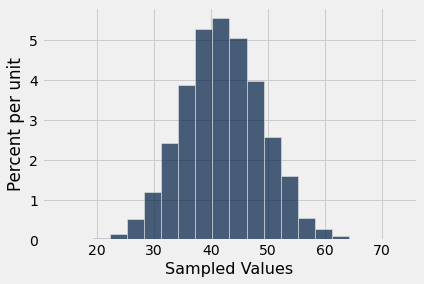

In [58]:
# Change the value of parameters! The sd must be > 0
mean = 42
sd = 7
# Don't change these lines below
from scipy.stats import norm
samples = norm.rvs(loc=mean, scale=sd, size=5000)
Table().with_column("Sampled Values", samples).hist(bins=20)
print(f"Mean of samples: '{np.mean(samples)}, STD of samples: '{np.std(samples)}'")

So how does the parametric bootstrap work? We sample some data, like normal, (non-parametric) bootstrapping. Then, instead of resampling from this data, we instead guess the distribution of our population, for example, guessing that it is normally distributed, and then we make a guess for the parameters of that distribution using our sample.

We then draw resamples from the population defined by this distribution that we guessed at, instead of from our sample data. We can use these resample to calculate CIs just as we would with our original resamples.

In [59]:
# Let's use the observations table!
guess_at_sd = np.std(observations.column(0))
guess_at_mean = np.mean(observations.column(0))
# We are going to use that as our parameter for generating the distribution, 
# and we are going to use a normal distribution as our guess for the shape.

# Let's walk through the bootstrap process now!
bootstrapped_sums = make_array()
num_sims = 1000
np.random.seed(8) # DO NOT CHANGE THIS LINE; This makes sure the random numbers you get are predictable
for i in np.arange(num_sims):
    sample = norm.rvs(loc=guess_at_mean, scale=guess_at_sd, size=observations.num_rows) # This samples from the distribution we guessed
    bootstrapped_sums = np.append(bootstrapped_sums, np.sum(sample))

Awesome! Now let's look at the confidence interval we generated using that method.

In [60]:
print(f"95% CI Lower Bound {percentile(2.5, bootstrapped_sums)} Upper Bound {percentile(97.5, bootstrapped_sums)}")

95% CI Lower Bound 418.8968914921205 Upper Bound 439.4895102699006


We generated a CI contains the true parameter, 432, just like when we could do with a normal (non-parametric) bootstrapping!

Hopefully this material is interesting! Remember this is completely out of scope! If you have any questions about this material please use the piazza thread and not office hours.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [61]:
grader.check_all()

q1_1 results: All test cases passed!

q1_2 results: All test cases passed!

q1_3 results: All test cases passed!

q1_4 results: All test cases passed!

q2_1 results: All test cases passed!

q2_2 results: All test cases passed!

q2_3 results: All test cases passed!

q2_4 results: All test cases passed!

q2_5 results: All test cases passed!

q3_1 results: All test cases passed!

q3_2 results: All test cases passed!

q4_1 results: All test cases passed!

q4_2 results: All test cases passed!

q4_3 results: All test cases passed!

q5_1 results: All test cases passed!

q5_2 results: All test cases passed!

q5_3 results: All test cases passed!

q5_4 results: All test cases passed!

q5_5 results: All test cases passed!

q5_6 results: All test cases passed!

q5_7 results: All test cases passed!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [ ]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)